# NAIVE BAYES STARTS HERE

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import string
import csv
import collections


In [436]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Hyperparameters and intitializations

In [0]:
classes = 3 


# Important functions

In [0]:
def accuracy(preds,true):
  correct = 0
  l = preds.shape[0]
  for ex in range(l):
    if (preds[ex] == true[ex]).all():
      correct+=1
  print(correct, " of", l, "predictions were correct")    
  acc = (correct/l)
  return acc    





In [0]:
tweets = []
labels = []

In [0]:
#Loadind the files
with open('/content/drive/My Drive/Tweets.csv') as tw:
  data = csv.reader(tw)
  for row in data:
    labels.append(row[0])
    tweets.append(row[1])

In [0]:
#Converting labels to coded labels

for r in range(len(labels)):
  if labels[r] == 'negative':
    labels[r] = 0
  if labels[r] == 'neutral':
    labels[r] = 1
  if labels[r] == 'positive':
    labels[r] = 2
        

In [0]:
#Deleting the header
tweets = np.asarray(np.delete(tweets,0))
labels = np.asarray(np.delete(labels,0),dtype=int)


# - Dataset Splitting function

In [0]:
def split_data(tweets,labels):

    # Counting total instances of each class
  neg = np.count_nonzero(labels == 0)
  neut = np.count_nonzero(labels == 1)
  pos = np.count_nonzero(labels == 2)

  # Sorting arrays so we can split the data

  sort_indices = np.argsort(labels)
  labels = labels[sort_indices]
  tweets = tweets[sort_indices]

  # Splitting train/test 80-20
  neg_tweets = tweets[0:neg]
  neg_labels = labels[0:neg]
  neut_tweets = tweets[neg:neg+neut]
  neut_labels = labels[neg:neg+neut]
  pos_tweets = tweets[neut+neg:]
  pos_labels = labels[neut+neg:]


  neg_num = int(np.ceil(0.9*neg))
  neut_num = int(np.ceil(0.9*neut))
  pos_num = int(np.ceil(0.9*pos))

  neg_train = neg_tweets[0:neg_num]
  neg_train_l = neg_labels[0:neg_num]

  neg_test = neg_tweets[neg_num:]
  neg_test_l = neg_labels[neg_num:]

  neut_train = neut_tweets[0:neut_num]
  neut_train_l = neut_labels[0:neut_num]

  neut_test = neut_tweets[neut_num:]
  neut_test_l = neut_labels[neut_num:]

                        
  pos_train = pos_tweets[0:pos_num]
  pos_train_l = pos_labels[0:pos_num]

  pos_test = pos_tweets[pos_num:]
  pos_test_l = pos_labels[pos_num:]


  train_data = np.hstack([neg_train,neut_train,pos_train])
  train_labels = np.hstack([neg_train_l,neut_train_l,pos_train_l])
  test_data = np.hstack([neg_test,neut_test,pos_test])
  test_labels = np.hstack([neg_test_l,neut_test_l,pos_test_l])

  # Sanity check
  print(len(train_data)+len(test_data),len(labels))


  #ONE hot
  shape = (train_labels.shape[0],classes)
  encoded = np.zeros(shape)
  rows = np.arange(train_labels.shape[0])
  encoded[rows,train_labels] = 1
  train_labels = encoded


  shape = (test_labels.shape[0],classes)
  encoded = np.zeros(shape)
  rows = np.arange(test_labels.shape[0])
  encoded[rows,test_labels] = 1
  test_labels = encoded

  
  # Shuffling the data
  
  index = np.arange(train_labels.shape[0])
  np.random.shuffle(index)
  train_labels = train_labels[index]
  train_data = train_data[index]
  
  dindex = np.arange(test_labels.shape[0])
  np.random.shuffle(dindex)
  test_labels = test_labels[dindex]
  test_data = test_data[dindex]

  
  return train_labels, train_data, test_labels, test_data

# Dataset Preprocessing function

In [0]:
Pos_Emoji=list(np.unique(('💜,✅,💗,💗,💘,💙,✔️,♥,💯,👍,💜✈,😘,⭐️,🙌,😆,😀,😎,👌,❤,💙,💝,😍,💕,😁,😋,👏,🌟,😅,😃,😳,😎,🙉,😻,💔,😜,😄,😆,😜,☀️,😁,😆,🎉,🍷,😀,💁,😂,😉,😮,😲,🎵,🍸,😉,😃,😂,😄,🎲,✌️').split(",")))
Neg_Emoji=list(np.unique(('❌,🚫,😫,😣,:(,😡,❌,😠,😷,👎,😕,😭,😢,😩,😵,😑,😐,😒,🙏,😤,😡,😖,😩,😞,👿,😥,😒,😷,😑,😩,😏').split(",")))
Neu_Emoji=list(np.unique(('👉,🚪,👀,😔,😊,✈️').split(",")))


In [0]:
pos_em = '😁'
neg_em = '😫'
neut_em = '👀'

In [0]:
ignore_list = ["a", "is," "about", "above", "after", "again", "against", "ain", "all", "am", "an", "and", "any", "are", "aren", "aren't", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "can", "couldn", "couldn't", "d", "did", "didn", "didn't", "do", "does", "doesn", "doesn't", "doing", "don", "don't", "down", "during", 'httpt','is','me','amp','hrs','min','via','"',"each", "few", "for", "from", "further", "had", "hadn", "hadn't", "has", "hasn", "hasn't", "have", "haven", "haven't", "having", "he", "her", "here", "hers", "herself", "him", "himself", "his", "how", "i", "if", "in", "into", "is", "isn", "isn't", "it", "it's", "its", "itself", "just", "ll", "m", "ma", "me", "mightn", "mightn't", "more", "most", "mustn", "mustn't", "my", "myself", "needn", "needn't", "no", "nor", "not", "now", "o", "of", "off", "on", "once", "only", "or", "other", "our", "ours", "ourselves", "out", "over", "own", "re", "s", "same", "shan", "shan't", "she", "she's", "should", "should've", "shouldn", "shouldn't", "so", "some", "such", "t", "than", "that", "that'll", "the", "their", "theirs", "them", "themselves", "then", "there", "these", "they", "this", "those", "through", "to", "too", "under", "until", "up", "ve", "very", "was", "wasn", "wasn't", "we", "were", "weren", "weren't", "what", "when", "where", "which", "while", "who", "whom", "why", "will", "with", "won", "won't", "wouldn", "wouldn't", "y", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves", "could", "he'd", "he'll", "he's", "here's", "how's", "i'd", "i'll", "i'm", "i've", "let's", "ought", "she'd", "she'll", "that's", "there's", "they'd", "they'll", "they're", "they've", "we'd", "we'll", "we're", "we've", "what's", "when's", "where's", "who's", "why's", "would",'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', 'couldn', 'didn', 'doesn', 'hadn', 'hasn', 'haven', 'isn', 'ma', 'mightn', 'mustn', 'needn', 'shan', 'shouldn', 'wasn', 'weren', 'won', 'wouldn',"always","a", "about", "above", "after", "again", "against", "ain", "all", "am", "an", "and", "any", "are", "aren"] 
               


In [1086]:
train_labels, train_data, test_labels, test_data = split_data(tweets,labels)

14640 14640


In [0]:
def make_dictionary(ignore_list, tweets):
  dictionary = {}

  for i in range(tweets.shape[0]):
    out = tweets[i].replace(',', ' ').replace('.', ' ').replace('!', ' ').replace('?', ' ').replace('http'," ")
    final = out.translate(str.maketrans('', '', string.punctuation))
    Text = final.replace(',', ' ').replace('.', ' ').replace('!', ' ').replace('?', ' ')
    rev = final.strip()
    rev = rev.split()
   
    for word in rev:
      word = word.lower()
      if word in ignore_list:
        continue
      elif(any(char.isdigit() for char in word)):
        continue
      if word in Pos_Emoji:
        word = pos_em
      elif word in Neg_Emoji:
        word = neg_em
      elif word in Neu_Emoji:
        word = neut_em
      
      if word in dictionary:
        dictionary[word] +=1
      else:
        
        dictionary.update({word:1})    
  return dictionary

In [0]:
def class_dictionary(ignore_list, tweets,labels):
  negative_dict = {}
  neutral_dict = {}
  positive_dict = {}
  for i in range(tweets.shape[0]):
    Text = tweets[i].replace(',', ' ').replace('.', ' ').replace('!', ' ').replace('?', ' ')
    final = Text.translate(str.maketrans('', '', string.punctuation))
    final = final.strip()
    rev = final.split()
    for word in rev:
      word = word.lower()
      if word in ignore_list:
        continue
      elif(any(char.isdigit() for char in word)):
        continue
      if word in Pos_Emoji:
        word = pos_em
      elif word in Neg_Emoji:
        word = neg_em
      elif word in Neu_Emoji:
        word = neut_em
      
      label_ind = np.argmax(labels[i])
      if(label_ind == 0):
        if word in negative_dict:
          negative_dict[word] +=1
        else:
          
          negative_dict.update({word:1})
      elif(label_ind == 1):
        if word in neutral_dict:
          neutral_dict[word] +=1
        else:
          
          neutral_dict.update({word:1})  
      elif(label_ind == 2):
        if word in positive_dict:
          positive_dict[word] +=1
        else:
          
          positive_dict.update({word:1})  
     




  return negative_dict, neutral_dict, positive_dict 

In [0]:
entire_corpus = make_dictionary(ignore_list,train_data)


In [0]:
negative_dict, neutral_dict, positive_dict = class_dictionary(ignore_list,train_data, train_labels)

In [0]:
class_d_list = [negative_dict,neutral_dict, positive_dict]

In [0]:
# Cleaning Function
def remove_words(class_d_list,corpus):

  for dic in class_d_list:
    class_words = list(dic.keys())
    for word in class_words:
      if word not in corpus:
        del dic[word]
  return class_d_list

In [0]:
# Laplace Smoothing
def add_one_smoothing(class_dict):
  corp_words = list(class_dict.keys())
  for word in corp_words:
    class_dict[word] +=1
  return class_dict      


In [0]:

negative_dict = add_one_smoothing(negative_dict)
neutral_dict = add_one_smoothing(neutral_dict)
positive_dict = add_one_smoothing(positive_dict)


In [0]:
# Add words from different classes
def add_missing(class_dict,corpus):
  corp_words = list(corpus.keys())
  for word in corp_words:
    if word not in class_dict:
      class_dict.update({word:1})
  return class_dict      

In [0]:
negative_dict = add_missing(negative_dict,entire_corpus)
neutral_dict = add_missing(neutral_dict,entire_corpus)
positive_dict = add_missing(positive_dict,entire_corpus)


In [0]:
# Cleaning Function
entire_corpus = {k: v for k, v in entire_corpus.items() if v >= 2 }
entire_corpus = {k: v for k, v in entire_corpus.items() if (len(k) >=3 and (k != pos_em) and (k != neg_em) and (k != neut_em))}



In [0]:

class_d_list = remove_words(class_d_list,entire_corpus)
negative_dict, neutral_dict, positive_dict = class_d_list


In [0]:
# Assigning log probs to words
def log_probs(class_dict):
  d_ = {}
  total_words = 0
  counts = list(class_dict.values())
  counts = np.sum(counts)
  print(counts)
  corpus = list(class_dict.keys())
  for word in corpus:
    prob = (class_dict[word]) / counts
    prob = np.log2(prob)
    d_.update({word:prob})
    
  return d_  


In [1107]:
negative_probs = log_probs(negative_dict)
neutral_probs = log_probs(neutral_dict)
positive_probs = log_probs(positive_dict)


87665
25149
21135


# Computing class priors

In [0]:
# Making a list of dictionaries for each class

In [0]:
class_dicts_list = [negative_probs,neutral_probs,positive_probs]

In [0]:
neg_prior = np.log2(np.sum(train_labels[:,0]) / train_labels.shape[0])
neut_prior = np.log2(np.sum(train_labels[:,1]) / train_labels.shape[0])
pos_prior = np.log2(np.sum(train_labels[:,2]) / train_labels.shape[0])
class_priors = [neg_prior,neut_prior,pos_prior]

# Naive Bayes starts here

In [0]:
def Naive_Bayes(class_priors,class_dicts_list,corpus,test_data,test_labels):
  preds = np.zeros_like(test_labels)  
  for i in range(len(test_data)):
    class_scores = []
    Text = test_data[i].replace(',', ' ').replace('.', ' ').replace('!', ' ').replace('?',' ')
    final = Text.translate(str.maketrans('', '', string.punctuation))
    final = final.strip()
    rev = final.split()
    clean_list = []
    
    for word in rev:
      word = word.lower()
      if word in ignore_list:
        continue
      if(any(char.isdigit() for char in word)): 
        continue  
      if word in Pos_Emoji:
        word = pos_em
      elif word in Neg_Emoji:
        word = neg_em
      elif word in Neu_Emoji:
        word = neut_em  
      else:
        word = word.lower()
        clean_list.append(word)   
    for dic in range(len(class_priors)):
      tot_prob = class_priors[dic] 
      for word in clean_list:
        if word not in corpus:
          continue;
        else:
          tot_prob += class_dicts_list[dic][word]
          
      class_scores.append(tot_prob)
    #print(class_scores)  
    highest = np.argmax(class_scores)

    preds[i,highest] = 1
    
  return preds



# Getting predictions 

In [0]:
predictions = Naive_Bayes(class_priors,class_dicts_list,entire_corpus,test_data,test_labels)


# Checking training & validation accuracy

In [1120]:
accuracy(predictions,test_labels)

1127  of 1462 predictions were correct


0.7708618331053352

# Evaluation metrics

In [0]:
def confusion_matrix(predictions,labels,mat):

  for ind,lab in enumerate(labels):
    tr = np.argmax(lab)
    pr = np.argmax(predictions[ind])
    mat[pr,tr] +=1
  return mat

In [0]:
conf_mat = np.zeros((classes,classes))

In [0]:
c = confusion_matrix(predictions,test_labels, conf_mat)

In [1124]:
c.shape

(3, 3)

In [0]:
# Function to extract from confusion matrix

def two_by_two(c,cl):
  mat = np.zeros((2,2))
  t_p = c[cl,cl]
  f_p = np.sum(c[cl]) - t_p
  f_n = np.sum(c[:,cl]) - t_p
  t_n = np.sum(c) - f_p - f_n - t_p
  mat[0,0] = t_p
  mat[0,1] = f_p
  mat[1,0] = f_n
  mat[1,1] = t_n
  return mat

# Evaluation metrics - Macro-Averaging

In [0]:
neg = two_by_two(c,0)
neut = two_by_two(c,1)
pos = two_by_two(c,2)



In [0]:
#mac_recall =  ((neg[0,0]/ np.sum(neg[:,0])) + (neut[0,0]/ np.sum(neut[:,0])) + (pos[0,0])/np.sum(pos[:,0])) / classes


In [0]:

mac_prec =( (neg[0,0]/np.sum(neg[0])) + ( (neut[0,0]) /(np.sum(neut[0]))) + ((pos[0,0]) /np.sum(pos[0])) ) / classes

mac_acc = ( ((np.sum(np.diag(neg))/np.sum(neg)) + (np.sum(np.diag(neut))/np.sum(neut)) + ( np.sum(np.diag(pos))))  /(np.sum(pos)))/ classes

mac_recall = ( (neg[0,0]/ np.sum(neg[:,0])) + (neut[0,0]/np.sum(neut[:,0])) + (pos[0,0])/np.sum(pos[:,0])  ) / classes

mac_f1 = (2*mac_prec*mac_recall)/( mac_prec + mac_recall)

# Evaluation metrics - Micro-Averaging


In [0]:
micro_prec = (neg[0,0] + neut[0,0] + pos[0,0]) / ((neg[0,1] + neut[0,1] + pos[0,1]) + (neg[0,0] + neut[0,0] + pos[0,0]))

micro_acc = (neg[1,1] + neut[1,1] + pos[1,1] +  neg[0,0] + neut[0,0] + pos[0,0]) / ( np.sum(neg) + np.sum(neut) + np.sum(pos))

micro_recall = (neg[0,0] + neut[0,0] + pos[0,0]) / (np.sum(neg[:,0]) + np.sum(neut[:,0]) +np.sum(pos[:,0]))

micro_f1 = (2*micro_prec*micro_recall)/ (micro_prec + micro_recall)

In [1150]:
micro_acc

0.8472412220702235

# Plots

# Confusion Matrix

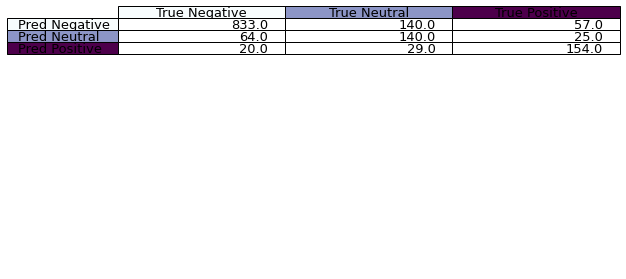

In [1151]:

# Prepare table
# Add a table at the bottom of the axes
c_colors = [["w","w","w"],[ "w","w","w"],[ "w","w","w"]]


columns = ('True Negative', 'True Neutral', 'True Positive')
rows = ['Pred Negative', 'Pred Neutral', 'Pred Positive']
# Get some pastel shades for the colors
colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
#c_colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
#r_colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
plt.axis('tight')
plt.axis('off')

cell_text = c
the_table = plt.table(
                      
                      cellText=cell_text,
                      rowLabels=rows,
                      rowColours=colors,
                      cellColours = c_colors,
                      colColours = colors,
                      colWidths = [0.5,0.5,0.5],
                      colLabels=columns,
                      fontsize = 0.9,
                      loc='top')

the_table.set_fontsize(13)
plt.show()

# Confusion matrix - Class Wise

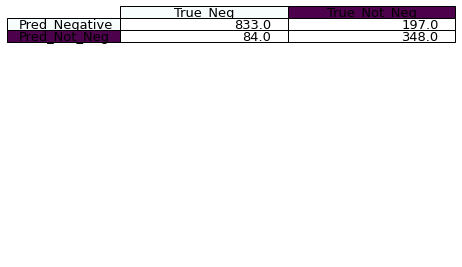

In [1152]:

# Prepare table
# Add a table at the bottom of the axes
c_colors = [["w","w"],[ "w","w"]]


columns = ('True_Neg', 'True_Not_Neg')
rows = ['Pred_Negative', 'Pred_Not_Neg']
# Get some pastel shades for the colors
colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
#c_colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
#r_colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
plt.axis('tight')
plt.axis('off')

cell_text = neg
the_table = plt.table(
                      
                      cellText=cell_text,
                      rowLabels=rows,
                      rowColours=colors,
                      cellColours = c_colors,
                      colColours = colors,
                      colWidths = [0.5,0.5],
                      colLabels=columns,
                      fontsize = 0.9,
                      loc='top')

the_table.set_fontsize(13)
plt.show()

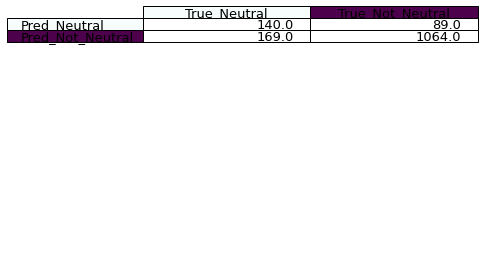

In [1153]:

# Prepare table
# Add a table at the bottom of the axes
c_colors = [["w","w"],[ "w","w"]]


columns = ('True_Neutral', 'True_Not_Neutral')
rows = ['Pred_Neutral', 'Pred_Not_Neutral']
# Get some pastel shades for the colors
colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
#c_colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
#r_colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
plt.axis('tight')
plt.axis('off')

cell_text = neut
the_table = plt.table(
                      
                      cellText=cell_text,
                      rowLabels=rows,
                      rowColours=colors,
                      cellColours = c_colors,
                      colColours = colors,
                      colWidths = [0.5,0.5],
                      colLabels=columns,
                      fontsize = 0.9,
                      loc='top')

the_table.set_fontsize(13)
plt.show()

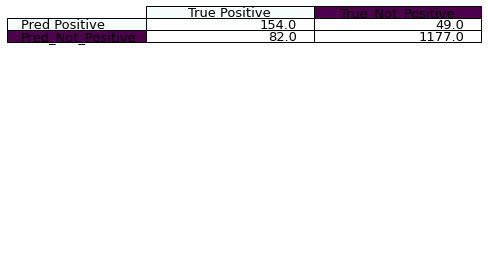

In [1154]:

# Prepare table
# Add a table at the bottom of the axes
c_colors = [["w","w"],[ "w","w"]]


columns = ('True Positive', 'True_Not_Positive')
rows = ['Pred Positive', 'Pred_Not_Positive']
# Get some pastel shades for the colors
colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
#c_colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
#r_colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
plt.axis('tight')
plt.axis('off')

cell_text = pos
the_table = plt.table(
                      
                      cellText=cell_text,
                      rowLabels=rows,
                      rowColours=colors,
                      cellColours = c_colors,
                      colColours = colors,
                      colWidths = [0.5,0.5],
                      colLabels=columns,
                      fontsize = 0.9,
                      loc='top')

the_table.set_fontsize(13)
plt.show()

# Plotting the metrics

In [1155]:
micro_recall

0.7708618331053352

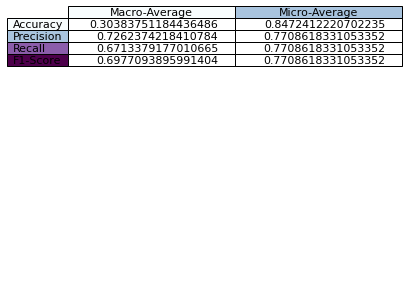

In [1156]:

# Prepare table
# Add a table at the bottom of the axes
c_colors = np.asarray(["w","w","w","w", "w","w","w","w"]).reshape(4,2)


columns = ('Macro-Average', 'Micro-Average')
rows = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
# Get some pastel shades for the colorsadam = Adam(lr=0.0005, beta_1=0.5)

colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
#c_colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
#r_colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
plt.axis('tight')
plt.axis('off')

cell_text = np.asarray([mac_acc,micro_acc,mac_prec,micro_prec,mac_recall, micro_recall ,mac_f1,micro_f1]).reshape(4,2)
the_table = plt.table(
                      
                      cellText=cell_text,
                      rowLabels=rows,
                      rowColours=colors,
                      cellColours = c_colors,
                      colColours = colors,
                      colWidths = [0.5,0.5],
                      colLabels=columns,
                      fontsize = 0.9,
                      loc='top')

the_table.set_fontsize(13)
plt.show()